# KMSD for Hyperspectral Target Detection

## Eqn 12 (MSD), Eqn 32 (KMSD)



<a href="#section1">1. HSI Data Loading & Pre-processing</a><br>
<a href="#section1.1" style="margin-left:20px">1.1. Load/Preprocess Data </a><br>
<a href="#section1.2" style="margin-left:20px">1.2. ROI Visualization - RGB Channels (436 X 449) </a><br>
<a href="#section1.3" style="margin-left:20px">1.3. ROI Ground Truth - RGB Channels (436 X 449) </a><br>
<a href="#section1.4" style="margin-left:20px">1.4. Background/Target Data With & Without MNF </a><br>
<a href="#section1.5" style="margin-left:20px">1.5. Reload Pickeld Files - Background/Target Data </a><br>

<a href="#section2">2. Performance On Data Without MNF</a><br>
<a href="#section2.1" style="margin-left:20px">2.1. Helper Functions </a><br>
<a href="#section2.2" style="margin-left:20px">2.2. MSD </a><br>
<a href="#section2.3" style="margin-left:20px">2.3. KMSD (Gaussian RBF Kernel) </a><br>
<a href="#section2.4" style="margin-left:20px">2.4. KMSD (Polynomial Kernel) </a><br>
<a href="#section2.5" style="margin-left:20px">2.5. KMSD (Spectral Angle Kernel) </a><br>


<a href="#section3">3. Performance On Data With MNF</a><br>
<a href="#section3.1" style="margin-left:20px">3.1. Helper Functions </a><br>
<a href="#section3.2" style="margin-left:20px">3.2. MSD </a><br>
<a href="#section3.3" style="margin-left:20px">3.3. KMSD (Gaussian RBF Kernel) </a><br>
<a href="#section3.4" style="margin-left:20px">3.4. KMSD (Polynomial Kernel) </a><br>
<a href="#section3.5" style="margin-left:20px">3.5. KMSD (Spectral Angle Kernel) </a><br>

<a href="#section4">4. Combined Plots  Results </a><br>

<a href="#section5">5. ROC curve </a><br>

In [1]:
import pickle as pkl
import numpy as np
import random
import sympy

import spectral.io.envi as envi
from spectral import *

import pysptools.noise as ns

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal

from PIL import Image
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

<a id="section1"></a>
# 1.  HSI Data Loading & Pre-processing

<a id="section1.1"></a>
## 1.1. Load & Preprocess Data

### MNF transform is done on line 6 & 7 below to getthe MNF version of  ROI (ROI_MNF)

In [2]:
ROI = envi.open('./data/subset_data100517.hdr', './data/subset_data100517')

ROI_MNF = envi.open('./data/Subset_data_MNF.hdr', './data/Subset_data_MNF')

print("ROI Shape:", ROI.shape)
print("ROI MNF Shape:", ROI_MNF.shape)

# wavelength: Red ~ 669, Green ~ 549, Blue ~ 474 
rgb_bands = (32, 20, 12)

target_pixels = [[222, 22], [222,23], [222,24], [222,25], [223,26],
                 [265,8], [265,17], [264,18], 
                 [265,32], [268, 32], [270,32], [268,29], [266,14], # x
                 [118,326], [121, 322], [125, 352], # x
                 [121,328], [122,340], 
                 [249, 366], [252,375], 
                 [322, 272], [342,293],
                 [384,102], [421,60], [422,63],
                 [326,258],
                 [338, 274],
                 [353, 290],
                 [317, 247]]

## Without MNF
target_spectrums = np.zeros((len(target_pixels), ROI.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums[i,:] = ROI[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums.shape)
avg_target_spectrum = np.sum(target_spectrums, axis=0)/len(target_pixels)
avg_target_spectrum = avg_target_spectrum.reshape(1,-1)
print(avg_target_spectrum.shape)
# target_spectrums = np.concatenate([target_spectrums, avg_target_spectrum], axis=0)
print(target_spectrums.shape)
print("---------")

## With MNF
target_spectrums_MNF = np.zeros((len(target_pixels), ROI_MNF.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums_MNF[i,:] = ROI_MNF[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums_MNF.shape)
avg_target_spectrum_MNF = np.sum(target_spectrums_MNF, axis=0)/len(target_pixels)
avg_target_spectrum_MNF = avg_target_spectrum_MNF.reshape(1,-1)
print(avg_target_spectrum_MNF.shape)
# target_spectrums_MNF = np.concatenate([target_spectrums_MNF, avg_target_spectrum_MNF], axis=0)
print(target_spectrums_MNF.shape)

ROI Shape: (436, 449, 187)
ROI MNF Shape: (436, 449, 187)
(29, 187)
(1, 187)
(29, 187)
---------
(29, 187)
(1, 187)
(29, 187)


<a id="section1.2"></a>
## 1.2. ROI Visualization - RGB Channels (436 x 449)

ROI_RGB Shape: (436, 449, 3)


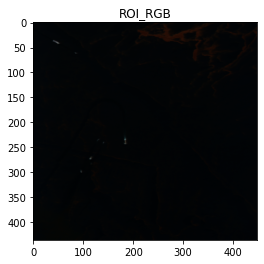

In [17]:
ROI_RGB = ROI[:,:,rgb_bands]
print("ROI_RGB Shape:", ROI_RGB.shape)
  
plt.imshow(ROI_RGB)
plt.title("ROI_RGB")
plt.savefig("./pics/ROI_RGB.png")

<a id="section1.3"></a>
## 1.3.  ROI Ground Truth Visualization - RGB Channels (436 x 449)

### Creating the 0/1 label for Orange fixels for oil spill & background pixels

GT_RGB  Shape: (436, 449, 3)


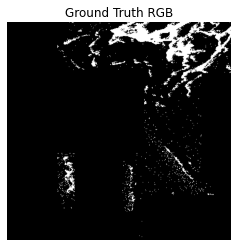

In [3]:
GT_RGB = np.zeros((ROI.shape[0], ROI.shape[1], 3))

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        # Using all spectral bands
        pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        pixel_dist = [np.sqrt(np.sum(target_spectrums[i,:] - pixel_spectrum)**2)
                for i in range(target_spectrums.shape[0])]
        
        min_dist_target_spectrum = min(pixel_dist)
        
#         print(min_dist_target_spectrum)

        if min_dist_target_spectrum >= 3e-1:
            GT_RGB[i,j,:] = 1    
            
print("GT_RGB  Shape:", GT_RGB.shape)  


for i in range(0,436):
    for j in range(0,101):
        GT_RGB[i,j,:] = 0
        
for i in range(96,262):
    for j in range(0,275):
        GT_RGB[i,j,:] = 0        

for i in range(346,436):
    for j in range(272,449):
        GT_RGB[i,j,:] = 0  

for i in range(256,436):
    for j in range(136,231):
        GT_RGB[i,j,:] = 0 
        
for i in range(380,436):
    for j in range(100,264):
        GT_RGB[i,j,:] = 0 

for i in range(102,321):
    for j in range(390,449):
        GT_RGB[i,j,:] = 0 

# save GT_RGB to be reloaded later directly if needed
with open("./kernel_data/GT_RGB.pkl","wb") as f:
    pkl.dump(GT_RGB, f)
    
plt.axis('off')
plt.imshow(GT_RGB)
plt.title("Ground Truth RGB")
plt.savefig("./pics/GT_RGB.png", bbox_inches='tight', transparent=True, pad_inches=0)

## Reload GT_RGB if saved earlier in sec 1.3

In [ ]:
# save GT_RGB to be reloaded later directly if needed
with open("./kernel_data/GT_RGB.pkl","rb") as f:
    GT_RGB = pkl.load(f)

<a id="section1.4"></a>
## 1.4.  Background/Target Data - With & Without MNF

### Using k-means clustering to select 100 representative pixels for background & target each

In [8]:
# Using k-means clustering to reduce data sample size
background, target = [], []
background_MNF, target_MNF = [], []

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        if sum(GT_RGB[i,j,:]) == 0.0:
            background.append(ROI[i, j, :].reshape(-1,1))
            background_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))
        else:
            target.append(ROI[i, j, :].reshape(-1,1))
            target_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))             

            
#### Without MNF ################
print("Starting Without MNF")
background = np.array(background)
background = background.reshape(background.shape[0], background.shape[1])
print("background Pixels Shape:", background.shape)

kmeans_background = KMeans(n_clusters=100, random_state=0).fit(background)
centroids_background = kmeans_background.cluster_centers_
centroids_background = centroids_background.T
print("Background Centroids Shape:", centroids_background.shape)


target = np.array(target)
target = target.reshape(target.shape[0], target.shape[1])
print("Target Pixels Shape:", target.shape)

kmeans_target = KMeans(n_clusters=100, random_state=0).fit(target)
centroids_target = kmeans_target.cluster_centers_
centroids_target = centroids_target.T
print("Target Centroids Shape:", centroids_target.shape)

#######################################

print("-------------")

#### Without MNF ################
print("Starting With MNF")
background_MNF = np.array(background_MNF)
background_MNF = background_MNF.reshape(background_MNF.shape[0], background_MNF.shape[1])
print("background_MNF Pixels Shape:", background_MNF.shape)

kmeans_background_MNF = KMeans(n_clusters=100, random_state=0).fit(background_MNF)
centroids_background_MNF = kmeans_background_MNF.cluster_centers_
centroids_background_MNF = centroids_background_MNF.T
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)


target_MNF = np.array(target_MNF)
target_MNF = target_MNF.reshape(target_MNF.shape[0], target_MNF.shape[1])
print("Target_MNF Pixels Shape:", target_MNF.shape)

kmeans_target_MNF = KMeans(n_clusters=100, random_state=0).fit(target_MNF)
centroids_target_MNF = kmeans_target_MNF.cluster_centers_
centroids_target_MNF = centroids_target_MNF.T
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)
#######################################

# Saving pickles files to be reloaded directly later in sec 1.5

with open("./kernel_data/background.pkl","wb") as f:
    pkl.dump(background, f)
    
with open("./kernel_data/target.pkl","wb") as f:
    pkl.dump(target, f)
    
with open("./kernel_data/background_MNF.pkl","wb") as f:
    pkl.dump(background_MNF, f)
    
with open("./kernel_data/target_MNF.pkl","wb") as f:
    pkl.dump(target_MNF, f)
    

with open("./kernel_data/centroids_background.pkl","wb") as f:
    pkl.dump(centroids_background, f)
    
with open("./kernel_data/centroids_target.pkl","wb") as f:
    pkl.dump(centroids_target, f)
    
with open("./kernel_data/centroids_background_MNF.pkl","wb") as f:
    pkl.dump(centroids_background_MNF, f)
    
with open("./kernel_data/centroids_target_MNF.pkl","wb") as f:
    pkl.dump(centroids_target_MNF, f)

Starting Without MNF
background Pixels Shape: (184805, 187)
Background Centroids Shape: (187, 100)
Target Pixels Shape: (10959, 187)
Target Centroids Shape: (100, 187)
-------------
Starting With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (187, 100)
Target_MNF Pixels Shape: (10959, 187)
Target_MNF Centroids Shape: (100, 187)


<a id="section1.5"></a>
## 1.5.  Reloading Pickeld Files - Background/Target Data

In [8]:
with open("./kernel_data/background.pkl","rb") as f:
    background = pkl.load(f)
    
with open("./kernel_data/target.pkl","rb") as f:
    target = pkl.load(f)
    
with open("./kernel_data/background_MNF.pkl","rb") as f:
    background_MNF = pkl.load(f)
    
with open("./kernel_data/target_MNF.pkl","rb") as f:
    target_MNF = pkl.load(f)
    

with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)

<a id="section2"></a>
# 2. Performance On Data Without MNF

<a id="section2.1"></a>
## 2.1.  Helper Functions

In [93]:
def significant_eigenvecs(matrix, n=100):
    cov_mat = np.cov(matrix)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    final_mat = np.zeros((matrix.shape[0], n))
    
    for i in range(n):
        final_mat[:,i] = eig_pairs[i][1]
        
    return final_mat

#Gaussian_Radial Basis Function (GRBF) kernel
# width of Gaussian RBF kernel, to be determined with trial & errors
C = 5
def kernel_GRBF(x, y, C=5):                     
    norm= np.linalg.norm(x - y)
    return np.exp(-1*norm*norm/C)


#Polynomial Kernel.
D     = 2 #power parameter of polynomial kernel, tbd
THETA = 10 #constant term for polynomial kernel, tbd

def kernel_poly(x,y, D = 2, THETA = 10):
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)
    val = np.power(np.dot(x,y)+THETA, D)
    val = val[0][0]
    return val

#Spectral angle_based kernel.
def kernel_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)    
    dot= np.dot(x,y)
    val = dot/(norm_x*norm_y)
    val = val[0][0]
    return val


def GRAM_MATRIX(sample_1, sample_2, kernel="Gaussian RBF"):
    K = np.zeros((sample_1.shape[1], sample_2.shape[1]))
    
    for i in range(sample_1.shape[1]):
        for j in range(sample_2.shape[1]):
            x = sample_1[:,i].reshape(-1,1)
            y = sample_2[:,j].reshape(-1,1)
            if kernel=="Gaussian RBF":
                K[i,j] = kernel_GRBF(x, y)
            elif kernel == "polynomial":
                K[i,j] = kernel_poly(x, y)
            elif kernel == "spectral angle":
                K[i,j] = kernel_spectral(x, y)
                
    return K

def K_ZT_y(y, kernel="Gaussian RBF"):
    x = []
    for i in range(centroids_target.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(centroids_target[:,i], y))
        elif kernel == "polynomial":
            x.append(kernel_poly(centroids_target[:,i], y))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(centroids_target[:,i], y))
            
    x = np.array(x).reshape(-1,1)
    return x

def K_ZB_y(y, kernel="Gaussian RBF"):
    x = []
    for i in range(centroids_background.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(centroids_background[:,i], y))
        elif kernel == "polynomial":
            x.append(kernel_poly(centroids_background[:,i], y))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(centroids_background[:,i], y))
            
    x = np.array(x).reshape(-1,1)
    return x

def KMSD(lambda_, y, Tau, Beta, Delta, kernel="Gaussian RBF"):
    k_zt_y = K_ZT_y(y, kernel = kernel)
    k_zb_y = K_ZB_y(y, kernel = kernel)
    
    k_ztb_y = np.concatenate([k_zt_y, k_zb_y], axis=0)
    
    numerator_term_1 = np.matmul(k_ztb_y.T, Delta)
    numerator_term_1 = np.matmul(numerator_term_1, Delta.T)
    numerator_term_1 = np.matmul(numerator_term_1, k_ztb_y)
    
    numerator_term_2 = np.matmul(k_zb_y.T, Beta)
    numerator_term_2 = np.matmul(numerator_term_2, Beta.T)
    numerator_term_2 = np.matmul(numerator_term_2, k_zb_y)
    
    numerator = numerator_term_1 - numerator_term_2
    
    
    denominator_term_1 = numerator_term_1
    
    denominator_term_2 = np.concatenate([np.matmul(k_zt_y.T, Tau), 
                                         np.matmul(k_zb_y.T, Beta)], axis=1)
    denominator_term_2 = np.matmul(denominator_term_2, lambda_)
    denominator_term_2 = np.matmul(denominator_term_2, 
                                  np.concatenate([np.matmul(Tau.T, k_zt_y),
                                                 np.matmul(Beta.T, k_zb_y)], axis=0))
    
    denominator = denominator_term_1 - denominator_term_2
    
    # EQN 32 of paper
    ratio = numerator/denominator
    
    return ratio[0][0]
    

<a id="section2.2"></a>
## 2.2.  Simple MSD

(187, 60)
(187, 60)


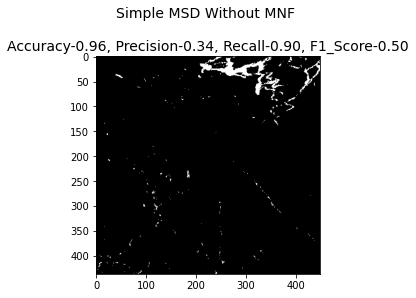

In [99]:
with open("./kernel_data/background.pkl","rb") as f:
    background = pkl.load(f)
    
with open("./kernel_data/target.pkl","rb") as f:
    target = pkl.load(f)

B = significant_eigenvecs(background.T, n = 60)
print(B.shape)   

T = significant_eigenvecs(target.T, n = 60)        
print(T.shape)   

P_B = np.matmul(B, B.T)
P_B = np.identity(187) - P_B

TB = np.concatenate([T, B], axis=1)

# X = [[T, B]^T [T, B]] = [T^T.T, T^T.B
#                          B^T.T, B^T.B]

row_1 = np.concatenate([np.matmul(T.T, T), np.matmul(T.T, B)], axis=1)
row_2 = np.concatenate([np.matmul(B.T, T), np.matmul(B.T, B)], axis=1)
tb = np.concatenate([row_1, row_2], axis=0)
tb_inv = np.linalg.inv(tb)

P_TB = np.matmul(np.matmul(TB, tb_inv), TB.T)
P_TB = np.identity(187) - P_TB


THRESHOLD = 9

def MSD(x):
    
#     print(x.shape)
    x = x.reshape(1, -1)
    
    numerator   = np.matmul(x, np.matmul(P_B, x.T))
    numerator   = numerator[0][0]
    denominator = np.matmul(x, np.matmul(P_TB, x.T))
    denominator = denominator[0][0]
    
    # EQN 12 of paper
    ratio = numerator/(denominator + 1e-5)
    
    return ratio

predictions_MSD = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_MSD = []

PREDS_MSD, GT_LABELS_MSD = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = MSD(current_pixel_spectrum)

#         print(y)

        if y >= THRESHOLD:
            predictions_MSD[i,j,:] = 1
        else:
            predictions_MSD[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_MSD.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_MSD.append(0)
        else:
            GT_LABELS_MSD.append(1)

        pred = sum(predictions_MSD[i,j,:])            
        if pred == 0.0:
            PREDS_MSD.append(0)
        else:
            PREDS_MSD.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_MSD.pkl","wb") as f:
    pkl.dump(predictions_MSD, f)
with open("./kernel_data/y_MSD.pkl","wb") as f:
    pkl.dump(y_MSD, f)
with open("./kernel_data/PREDS_MSD.pkl","wb") as f:
    pkl.dump(PREDS_MSD, f)
with open("./kernel_data/GT_LABELS_MSD.pkl","wb") as f:
    pkl.dump(GT_LABELS_MSD, f) 

accuracy = accuracy_score(PREDS_MSD, GT_LABELS_MSD)
precision = precision_score(PREDS_MSD, GT_LABELS_MSD)
recall = recall_score(PREDS_MSD, GT_LABELS_MSD)
f1 = f1_score(PREDS_MSD, GT_LABELS_MSD)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_MSD)
plt.title("Simple MSD Without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/MSD.png")

<a id="section2.3"></a>
## 2.3.  KMSD (Gaussian RBF Kernel)

lambda_ shape: (200, 200)


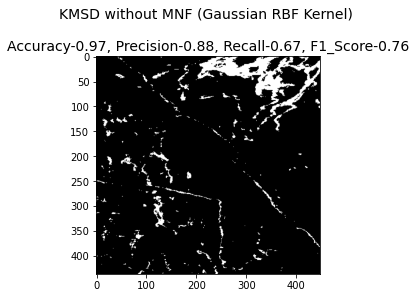

In [46]:
with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
K_ZB_ZB = GRAM_MATRIX(centroids_background, centroids_background, kernel = "Gaussian RBF")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target, centroids_target, kernel = "Gaussian RBF")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB = np.concatenate([centroids_target, centroids_background], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB, combined_TB, kernel = "Gaussian RBF")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target, centroids_background, kernel = "Gaussian RBF")
K_ZB_ZT = GRAM_MATRIX(centroids_background, centroids_target, kernel = "Gaussian RBF")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

    
THRESHOLD = .4

predictions_KMSD_GRBF = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KMSD_GRBF = []

PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "Gaussian RBF")

#         print(y)

        if y >= THRESHOLD:
            predictions_KMSD_GRBF[i,j,:] = 1
        else:
            predictions_KMSD_GRBF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_GRBF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_GRBF.append(0)
        else:
            GT_LABELS_KMSD_GRBF.append(1)

        pred = sum(predictions_KMSD_GRBF[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_GRBF.append(0)
        else:
            PREDS_KMSD_GRBF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_GRBF.pkl","wb") as f:
    pkl.dump(predictions_KMSD_GRBF, f)
with open("./kernel_data/y_KMSD_GRBF.pkl","wb") as f:
    pkl.dump(y_KMSD_GRBF, f)
with open("./kernel_data/PREDS_KMSD_GRBF.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_GRBF, f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_GRBF, f) 
    
       
    
accuracy = accuracy_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
precision = precision_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
recall = recall_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
f1 = f1_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_GRBF)
plt.title("KMSD without MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_GRBF.png")

<a id="section2.4"></a>
## 2.4.  KMSD (Polynomial Kernel)

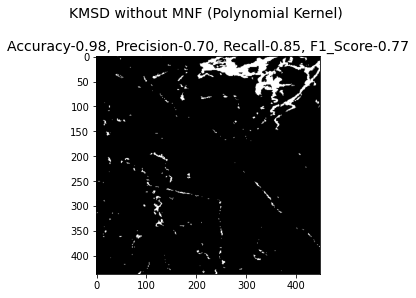

In [41]:
with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
K_ZB_ZB = GRAM_MATRIX(centroids_background, centroids_background, kernel = "polynomial")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target, centroids_target, kernel = "polynomial")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB = np.concatenate([centroids_target, centroids_background], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB, combined_TB, kernel = "polynomial")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target, centroids_background, kernel = "polynomial")
K_ZB_ZT = GRAM_MATRIX(centroids_background, centroids_target, kernel = "polynomial")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

THRESHOLD = .54

predictions_KMSD_Polynomial = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KMSD_Polynomial = []

PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "polynomial")
        
#         print(y)

        if y >= THRESHOLD:
            predictions_KMSD_Polynomial[i,j,:] = 1
        else:
            predictions_KMSD_Polynomial[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_Polynomial.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_Polynomial.append(0)
        else:
            GT_LABELS_KMSD_Polynomial.append(1)

        pred = sum(predictions_KMSD_Polynomial[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_Polynomial.append(0)
        else:
            PREDS_KMSD_Polynomial.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_Polynomial.pkl","wb") as f:
    pkl.dump(predictions_KMSD_Polynomial, f)
with open("./kernel_data/y_KMSD_Polynomial.pkl","wb") as f:
    pkl.dump(y_KMSD_Polynomial, f)
with open("./kernel_data/PREDS_KMSD_Polynomial.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_Polynomial, f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_Polynomial, f)             
            
accuracy = accuracy_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
precision = precision_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
recall = recall_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
f1 = f1_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_Polynomial)
plt.title("KMSD without MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_Polynomial.png")

<a id="section2.5"></a>
## 2.5.  KMSD (Spectral Angle Kernel)

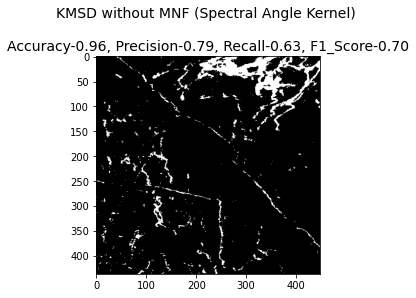

In [43]:
with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
    
K_ZB_ZB = GRAM_MATRIX(centroids_background, centroids_background, kernel = "spectral angle")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target, centroids_target, kernel = "spectral angle")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB = np.concatenate([centroids_target, centroids_background], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB, combined_TB, kernel = "spectral angle")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target, centroids_background, kernel = "spectral angle")
K_ZB_ZT = GRAM_MATRIX(centroids_background, centroids_target, kernel = "spectral angle")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

THRESHOLD = .5

predictions_KMSD_SpectralAngle = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_KMSD_SpectralAngle = []

PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "spectral angle")
        
#         print(y)

        if y >= THRESHOLD:
            predictions_KMSD_SpectralAngle[i,j,:] = 1
        else:
            predictions_KMSD_SpectralAngle[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_SpectralAngle.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_SpectralAngle.append(0)
        else:
            GT_LABELS_KMSD_SpectralAngle.append(1)

        pred = sum(predictions_KMSD_SpectralAngle[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_SpectralAngle.append(0)
        else:
            PREDS_KMSD_SpectralAngle.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_SpectralAngle.pkl","wb") as f:
    pkl.dump(predictions_KMSD_SpectralAngle, f)
with open("./kernel_data/y_KMSD_SpectralAngle.pkl","wb") as f:
    pkl.dump(y_KMSD_SpectralAngle, f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_SpectralAngle, f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_SpectralAngle, f) 

accuracy = accuracy_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
precision = precision_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
recall = recall_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
f1 = f1_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_SpectralAngle)
plt.title("KMSD without MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_SpectralAngle.png")

<a id="section3"></a>
## 3.  Performance on Data With MNF

<a id="section3.1"></a>
## 3.1.  Helper Functions

### Mostly same as sec 2.1 (Helper Functions) except some changes in constants C, D, THETA if needed

In [4]:
def significant_eigenvecs(matrix, n=100):
    cov_mat = np.cov(matrix)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    final_mat = np.zeros((matrix.shape[0], n))
    
    for i in range(n):
        final_mat[:,i] = eig_pairs[i][1]
        
    return final_mat

#Gaussian_Radial Basis Function (GRBF) kernel
# width of Gaussian RBF kernel, to be determined with trial & errors
C = 1e5
def kernel_GRBF(x, y, C=1e5):                     
    norm= np.linalg.norm(x - y)
#     print("**")
#     print(norm)
    val = np.exp(-1*norm*norm/C)
#     print(val)
#     print("---")
    return val


#Polynomial Kernel.
D     = 2 #power parameter of polynomial kernel, tbd
THETA = 10 #constant term for polynomial kernel, tbd

def kernel_poly(x,y, D = 2, THETA =10):
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)
#     print("------")    
#     print(np.dot(x,y))
    val = np.power(np.dot(x,y)/1000+THETA, D)
    val = val[0][0]
#     print(val)
#     print("*****")
    return val

#Spectral angle_based kernel.
def kernel_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    x = x.reshape(1,-1)
    y = y.reshape(-1,1)    
    dot= np.dot(x,y)
    val = dot/(norm_x*norm_y)
    val = val[0][0]
    return val


def GRAM_MATRIX(sample_1, sample_2, kernel="Gaussian RBF"):
    K = np.zeros((sample_1.shape[1], sample_2.shape[1]))
    
    for i in range(sample_1.shape[1]):
        for j in range(sample_2.shape[1]):
            x = sample_1[:,i].reshape(-1,1)
            y = sample_2[:,j].reshape(-1,1)
            if kernel=="Gaussian RBF":
                K[i,j] = kernel_GRBF(x, y)
            elif kernel == "polynomial":
                K[i,j] = kernel_poly(x, y)
            elif kernel == "spectral angle":
                K[i,j] = kernel_spectral(x, y)
                
    return K

def K_ZT_y(y, kernel="Gaussian RBF"):
    x = []
    for i in range(centroids_target_MNF.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(centroids_target_MNF[:,i], y))
        elif kernel == "polynomial":
            x.append(kernel_poly(centroids_target_MNF[:,i], y))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(centroids_target_MNF[:,i], y))
            
    x = np.array(x).reshape(-1,1)
    return x

def K_ZB_y(y, kernel="Gaussian RBF"):
    x = []
    for i in range(centroids_background_MNF.shape[1]):
        if kernel == "Gaussian RBF":
            x.append(kernel_GRBF(centroids_background_MNF[:,i], y))
        elif kernel == "polynomial":
            x.append(kernel_poly(centroids_background_MNF[:,i], y))
        elif kernel == "spectral angle":
            x.append(kernel_spectral(centroids_background_MNF[:,i], y))
            
    x = np.array(x).reshape(-1,1)
    return x

def KMSD(lambda_, y, Tau, Beta, Delta, kernel="Gaussian RBF"):
    k_zt_y = K_ZT_y(y, kernel = kernel)
    k_zb_y = K_ZB_y(y, kernel = kernel)
    
    k_ztb_y = np.concatenate([k_zt_y, k_zb_y], axis=0)
    
    numerator_term_1 = np.matmul(k_ztb_y.T, Delta)
    numerator_term_1 = np.matmul(numerator_term_1, Delta.T)
    numerator_term_1 = np.matmul(numerator_term_1, k_ztb_y)
    
    numerator_term_2 = np.matmul(k_zb_y.T, Beta)
    numerator_term_2 = np.matmul(numerator_term_2, Beta.T)
    numerator_term_2 = np.matmul(numerator_term_2, k_zb_y)
    
    numerator = numerator_term_1 - numerator_term_2
    
    
    denominator_term_1 = numerator_term_1
    
    denominator_term_2 = np.concatenate([np.matmul(k_zt_y.T, Tau), 
                                         np.matmul(k_zb_y.T, Beta)], axis=1)
    denominator_term_2 = np.matmul(denominator_term_2, lambda_)
    denominator_term_2 = np.matmul(denominator_term_2, 
                                  np.concatenate([np.matmul(Tau.T, k_zt_y),
                                                 np.matmul(Beta.T, k_zb_y)], axis=0))
    
    denominator = denominator_term_1 - denominator_term_2
    
    # Eqn 32 of paper
    ratio = numerator/denominator
    
    return ratio[0][0]
    

<a id="section3.2"></a>
## 3.2.  Simple MSD with MNF Data

(187, 80)
(187, 80)


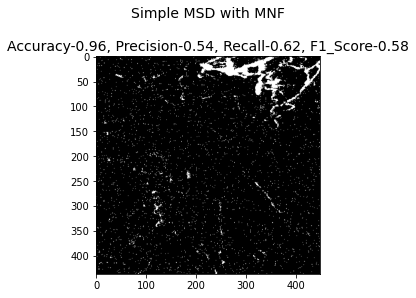

In [16]:
with open("./kernel_data/background_MNF.pkl","rb") as f:
    background_MNF = pkl.load(f)
    
with open("./kernel_data/target_MNF.pkl","rb") as f:
    target_MNF = pkl.load(f)

B = significant_eigenvecs(background_MNF.T, n=80)        
print(B.shape)   

T = significant_eigenvecs(target_MNF.T, n=80)        
print(T.shape)

P_B = np.matmul(B, B.T)
P_B = np.identity(187) - P_B

TB = np.concatenate([T, B], axis=1)

# X = [[T, B]^T [T, B]] = [T^T.T, T^T.B
#                          B^T.T, B^T.B]

row_1 = np.concatenate([np.matmul(T.T, T), np.matmul(T.T, B)], axis=1)
row_2 = np.concatenate([np.matmul(B.T, T), np.matmul(B.T, B)], axis=1)
tb = np.concatenate([row_1, row_2], axis=0)
tb_inv = np.linalg.inv(tb)

P_TB = np.matmul(np.matmul(TB, tb_inv), TB.T)
P_TB = np.identity(187) - P_TB

THRESHOLD = 7


def MSD(x):
    
#     print(x.shape)
    x = x.reshape(1, -1)
    
    numerator   = np.matmul(x, np.matmul(P_B, x.T))
    numerator   = numerator[0][0]
    denominator = np.matmul(x, np.matmul(P_TB, x.T))
    denominator = denominator[0][0]
    
    # Eqn 12 of paper
    ratio = numerator/denominator
    
    return ratio

predictions_MSD_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_MSD_MNF = []

PREDS_MSD_MNF, GT_LABELS_MSD_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = MSD(current_pixel_spectrum)

#         print(y)

        if y >= THRESHOLD:        
            predictions_MSD_MNF[i,j,:] = 1
        else:
            predictions_MSD_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_MSD_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_MSD_MNF.append(0)
        else:
            GT_LABELS_MSD_MNF.append(1)

        pred = sum(predictions_MSD_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_MSD_MNF.append(0)
        else:
            PREDS_MSD_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_MSD_MNF.pkl","wb") as f:
    pkl.dump(predictions_MSD_MNF, f)
with open("./kernel_data/y_MSD_MNF.pkl","wb") as f:
    pkl.dump(y_MSD_MNF, f)
with open("./kernel_data/PREDS_MSD_MNF.pkl","wb") as f:
    pkl.dump(PREDS_MSD_MNF, f)
with open("./kernel_data/GT_LABELS_MSD_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_MSD_MNF, f) 
    

accuracy = accuracy_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
precision = precision_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
recall = recall_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
f1 = f1_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_MSD_MNF)
plt.title("Simple MSD with MNF\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/MSD_MNF.png")

<a id="section3.3"></a>
## 3.3.  KMSD (Gaussian RBF Kernel) with MNF Data

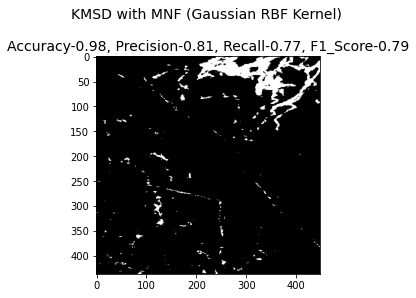

In [12]:
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)
    
    
K_ZB_ZB = GRAM_MATRIX(centroids_background_MNF, centroids_background_MNF, kernel = "Gaussian RBF")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target_MNF, centroids_target_MNF, kernel = "Gaussian RBF")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB_MNF = np.concatenate([centroids_target_MNF, centroids_background_MNF], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB_MNF, combined_TB_MNF, kernel = "Gaussian RBF")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target_MNF, centroids_background_MNF, kernel = "Gaussian RBF")
K_ZB_ZT = GRAM_MATRIX(centroids_background_MNF, centroids_target_MNF, kernel = "Gaussian RBF")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

THRESHOLD = .503


predictions_KMSD_GRBF_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KMSD_GRBF_MNF = []

PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "Gaussian RBF")
        
#         print(y)

        if y >= THRESHOLD:        
            predictions_KMSD_GRBF_MNF[i,j,:] = 1
        else:
            predictions_KMSD_GRBF_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_GRBF_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_GRBF_MNF.append(0)
        else:
            GT_LABELS_KMSD_GRBF_MNF.append(1)

        pred = sum(predictions_KMSD_GRBF_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_GRBF_MNF.append(0)
        else:
            PREDS_KMSD_GRBF_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_GRBF_MNF.pkl","wb") as f:
    pkl.dump(predictions_KMSD_GRBF_MNF, f)
with open("./kernel_data/y_KMSD_GRBF_MNF.pkl","wb") as f:
    pkl.dump(y_KMSD_GRBF_MNF, f)
with open("./kernel_data/PREDS_KMSD_GRBF_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_GRBF_MNF, f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_GRBF_MNF, f) 


accuracy = accuracy_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
precision = precision_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
recall = recall_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
f1 = f1_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_GRBF_MNF)
plt.title("KMSD with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_GRBF_MNF.png")

<a id="section3.4"></a>
## 3.4.  KMSD (Polynomial Kernel) with MNF Data

lambda_ shape: (200, 200)


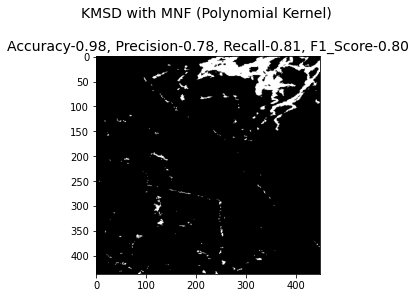

In [10]:
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)
    
    
K_ZB_ZB = GRAM_MATRIX(centroids_background_MNF, centroids_background_MNF, kernel = "polynomial")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target_MNF, centroids_target_MNF, kernel = "polynomial")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB_MNF = np.concatenate([centroids_target_MNF, centroids_background_MNF], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB_MNF, combined_TB_MNF, kernel = "polynomial")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target_MNF, centroids_background_MNF, kernel = "polynomial")
K_ZB_ZT = GRAM_MATRIX(centroids_background_MNF, centroids_target_MNF, kernel = "polynomial")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

THRESHOLD = .51

predictions_KMSD_Polynomial_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KMSD_Polynomial_MNF = []

PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "polynomial")

#         print(y)

        if y >= THRESHOLD:
            predictions_KMSD_Polynomial_MNF[i,j,:] = 1
        else:
            predictions_KMSD_Polynomial_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_Polynomial_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_Polynomial_MNF.append(0)
        else:
            GT_LABELS_KMSD_Polynomial_MNF.append(1)

        pred = sum(predictions_KMSD_Polynomial_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_Polynomial_MNF.append(0)
        else:
            PREDS_KMSD_Polynomial_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(predictions_KMSD_Polynomial_MNF, f)
with open("./kernel_data/y_KMSD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(y_KMSD_Polynomial_MNF, f)
with open("./kernel_data/PREDS_KMSD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_Polynomial_MNF, f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_Polynomial_MNF, f)             


accuracy = accuracy_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
precision = precision_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
recall = recall_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
f1 = f1_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_Polynomial_MNF)
plt.title("KMSD with MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_Polynomial_MNF.png")

<a id="section3.5"></a>
## 3.5. KMSD (Spectral Angle Kernel) with MNF Data

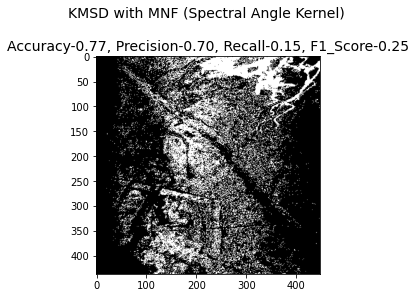

In [2]:
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)

    
K_ZB_ZB = GRAM_MATRIX(centroids_background_MNF, centroids_background_MNF, kernel = "spectral angle")
_, Beta = np.linalg.eig(K_ZB_ZB)

K_ZT_ZT = GRAM_MATRIX(centroids_target_MNF, centroids_target_MNF, kernel = "spectral angle")
_, Tau = np.linalg.eig(K_ZT_ZT)

combined_TB_MNF = np.concatenate([centroids_target_MNF, centroids_background_MNF], axis=1)
K_ZTB_ZTB = GRAM_MATRIX(combined_TB_MNF, combined_TB_MNF, kernel = "spectral angle")
_, Delta = np.linalg.eig(K_ZTB_ZTB)

K_ZT_ZB = GRAM_MATRIX(centroids_target_MNF, centroids_background_MNF, kernel = "spectral angle")
K_ZB_ZT = GRAM_MATRIX(centroids_background_MNF, centroids_target_MNF, kernel = "spectral angle")

lambda_11 = np.matmul(np.matmul(Tau.T, K_ZT_ZT), Tau)
lambda_12 = np.matmul(np.matmul(Tau.T, K_ZT_ZB), Beta)
lambda_21 = np.matmul(np.matmul(Beta.T, K_ZB_ZT), Tau)
lambda_22 = np.matmul(np.matmul(Beta.T, K_ZB_ZB), Beta)

lambda_1 = np.concatenate([lambda_11, lambda_12], axis=1)
lambda_2 = np.concatenate([lambda_21, lambda_22], axis=1)
lambda_ = np.concatenate([lambda_1, lambda_2], axis=0)
lambda_ = np.linalg.inv(lambda_)
print("lambda_ shape:", lambda_.shape)

THRESHOLD = .675 # .46
# THRESHOLD = .6

predictions_KMSD_SpectralAngle_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_KMSD_SpectralAngle_MNF = []

PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:]

        y = KMSD(lambda_, current_pixel_spectrum,  Tau, Beta, Delta, kernel = "spectral angle")

#         print(y)

        if y >= THRESHOLD:
            predictions_KMSD_SpectralAngle_MNF[i,j,:] = 1
        else:
            predictions_KMSD_SpectralAngle_MNF[i,j,:] = 0

        # save y value for thresholding for ROC curve later
        y_KMSD_SpectralAngle_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_KMSD_SpectralAngle_MNF.append(0)
        else:
            GT_LABELS_KMSD_SpectralAngle_MNF.append(1)

        pred = sum(predictions_KMSD_SpectralAngle_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_KMSD_SpectralAngle_MNF.append(0)
        else:
            PREDS_KMSD_SpectralAngle_MNF.append(1)        

# save results to be reloaded directly later
with open("./kernel_data/predictions_KMSD_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(predictions_KMSD_SpectralAngle_MNF, f)
with open("./kernel_data/y_KMSD_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(y_KMSD_SpectralAngle_MNF, f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KMSD_SpectralAngle_MNF, f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KMSD_SpectralAngle_MNF, f) 
    
accuracy = accuracy_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
precision = precision_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
recall = recall_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
f1 = f1_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)

# print("accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".format(accuracy, precision, recall, f1))

plt.imshow(predictions_KMSD_SpectralAngle_MNF)
plt.title("KMSD with MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)

plt.savefig("./pics/KMSD_SpectralAngle_MNF.png")

<a id="section4"></a>
## 4. Combined Plots - Results

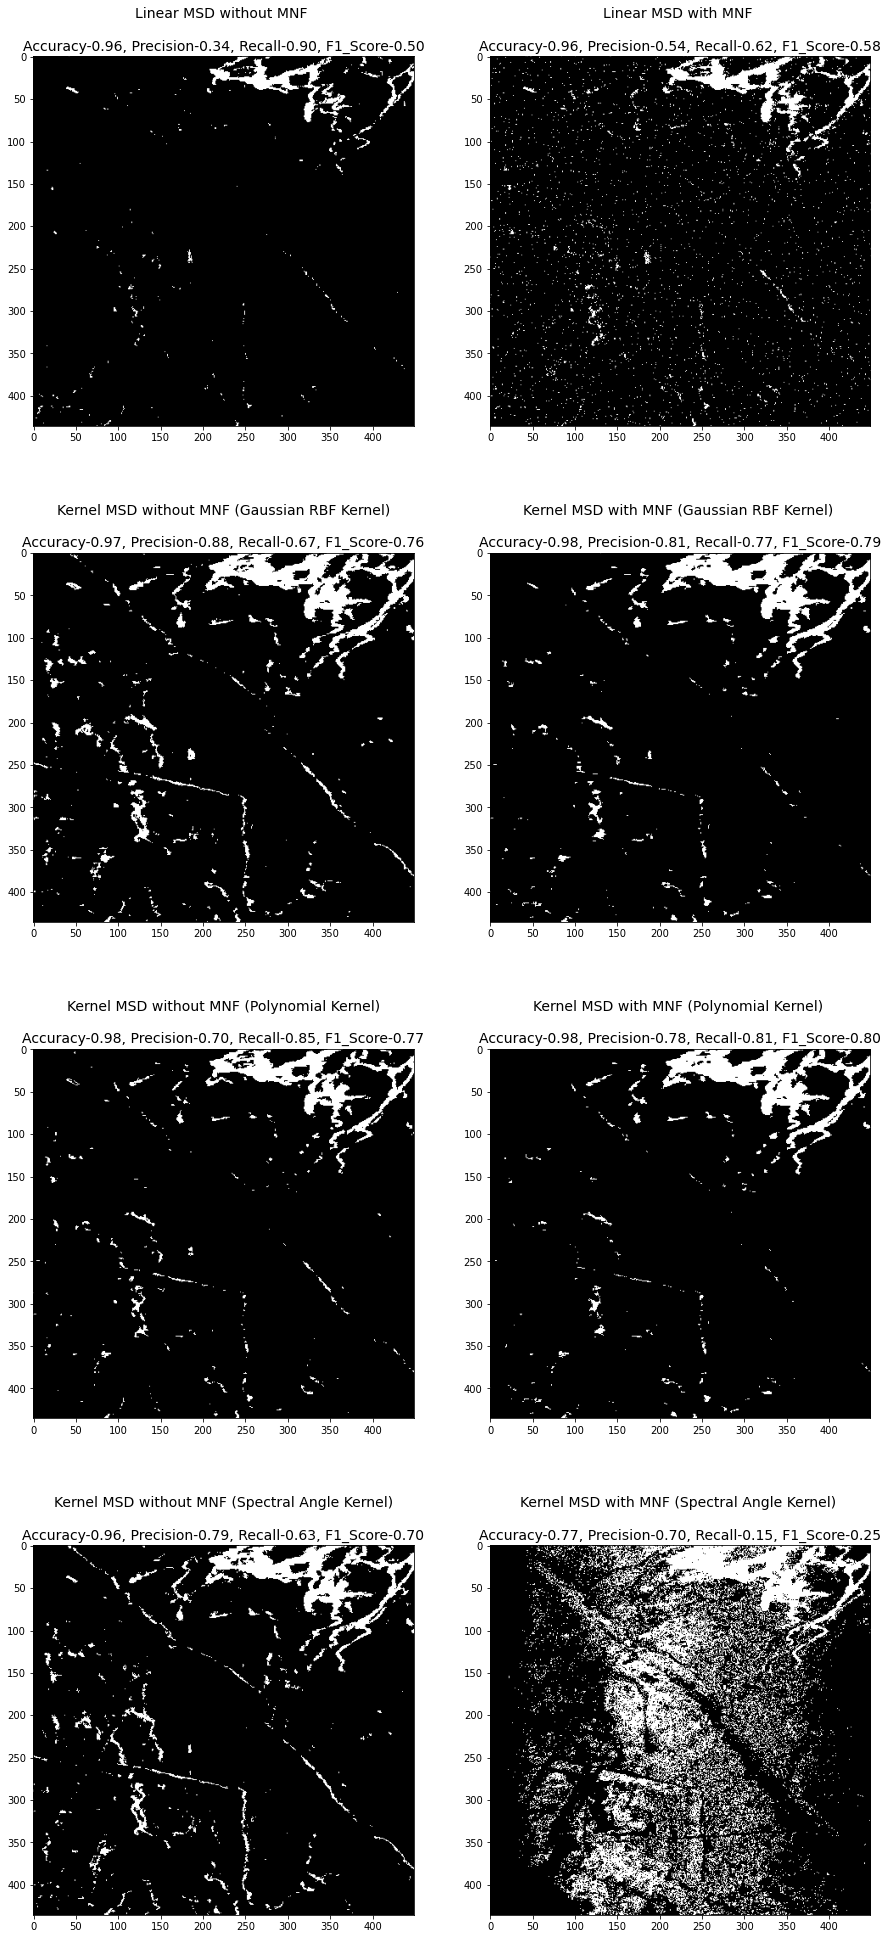

In [13]:
# plt.figure(figsize=(20,15))

plt.figure(figsize=(15,35))

###################################### Linear MSD ###########################################################
plt.subplot(421)
with open("./kernel_data/predictions_MSD.pkl","rb") as f:
    predictions_MSD = pkl.load(f)
with open("./kernel_data/PREDS_MSD.pkl","rb") as f:
    PREDS_MSD = pkl.load(f)
with open("./kernel_data/GT_LABELS_MSD.pkl","rb") as f:
    GT_LABELS_MSD = pkl.load(f)
    
accuracy = accuracy_score(PREDS_MSD, GT_LABELS_MSD)
precision = precision_score(PREDS_MSD, GT_LABELS_MSD)
recall = recall_score(PREDS_MSD, GT_LABELS_MSD)
f1 = f1_score(PREDS_MSD, GT_LABELS_MSD)

plt.imshow(predictions_MSD)
plt.title("Linear MSD without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(422)
with open("./kernel_data/predictions_MSD_MNF.pkl","rb") as f:
    predictions_MSD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_MSD_MNF.pkl","rb") as f:
    PREDS_MSD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_MSD_MNF.pkl","rb") as f:
    GT_LABELS_MSD_MNF = pkl.load(f)

accuracy = accuracy_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
precision = precision_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
recall = recall_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)
f1 = f1_score(PREDS_MSD_MNF, GT_LABELS_MSD_MNF)

plt.imshow(predictions_MSD_MNF)
plt.title("Linear MSD with MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################
    
###################################### Gaussian RBF Kernel ###########################################################
plt.subplot(423)
with open("./kernel_data/predictions_KMSD_GRBF.pkl","rb") as f:
    predictions_KMSD_GRBF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_GRBF.pkl","rb") as f:
    PREDS_KMSD_GRBF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF.pkl","rb") as f:
    GT_LABELS_KMSD_GRBF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
precision = precision_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
recall = recall_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)
f1 = f1_score(PREDS_KMSD_GRBF, GT_LABELS_KMSD_GRBF)

plt.imshow(predictions_KMSD_GRBF)
plt.title("\nKernel MSD without MNF (Gaussian RBF Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(424)
with open("./kernel_data/predictions_KMSD_GRBF_MNF.pkl","rb") as f:
    predictions_KMSD_GRBF_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_GRBF_MNF.pkl","rb") as f:
    PREDS_KMSD_GRBF_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_GRBF_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
precision = precision_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
recall = recall_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)
f1 = f1_score(PREDS_KMSD_GRBF_MNF, GT_LABELS_KMSD_GRBF_MNF)

plt.imshow(predictions_KMSD_GRBF_MNF)
plt.title("\nKernel MSD with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

###################################### Polynomial Kernel ###########################################################
plt.subplot(425)
with open("./kernel_data/predictions_KMSD_Polynomial.pkl","rb") as f:
    predictions_KMSD_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_Polynomial.pkl","rb") as f:
    PREDS_KMSD_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial.pkl","rb") as f:
    GT_LABELS_KMSD_Polynomial = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
precision = precision_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
recall = recall_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)
f1 = f1_score(PREDS_KMSD_Polynomial, GT_LABELS_KMSD_Polynomial)

plt.imshow(predictions_KMSD_Polynomial)
plt.title("\nKernel MSD without MNF (Polynomial Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(426)
with open("./kernel_data/predictions_KMSD_Polynomial_MNF.pkl","rb") as f:
    predictions_KMSD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_Polynomial_MNF.pkl","rb") as f:
    PREDS_KMSD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_Polynomial_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
precision = precision_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
recall = recall_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)
f1 = f1_score(PREDS_KMSD_Polynomial_MNF, GT_LABELS_KMSD_Polynomial_MNF)

plt.imshow(predictions_KMSD_Polynomial_MNF)
plt.title("\nKernel MSD with MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################


###################################### Spectral Angle Kernel ###########################################################
plt.subplot(427)
with open("./kernel_data/predictions_KMSD_SpectralAngle.pkl","rb") as f:
    predictions_KMSD_SpectralAngle = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle.pkl","rb") as f:
    PREDS_KMSD_SpectralAngle = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle.pkl","rb") as f:
    GT_LABELS_KMSD_SpectralAngle = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
precision = precision_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
recall = recall_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)
f1 = f1_score(PREDS_KMSD_SpectralAngle, GT_LABELS_KMSD_SpectralAngle)

plt.imshow(predictions_KMSD_SpectralAngle)
plt.title("\nKernel MSD without MNF (Spectral Angle Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(428)
with open("./kernel_data/predictions_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    predictions_KMSD_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    PREDS_KMSD_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_SpectralAngle_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
precision = precision_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
recall = recall_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)
f1 = f1_score(PREDS_KMSD_SpectralAngle_MNF, GT_LABELS_KMSD_SpectralAngle_MNF)

plt.imshow(predictions_KMSD_SpectralAngle_MNF)
plt.title("\nKernel MSD with MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

plt.savefig("./pics/MSD_KMSD_Combined_Results.png", bbox_inches='tight', pad_inches=.5)

<a id="section6"></a>
## 6.  ROC Curve

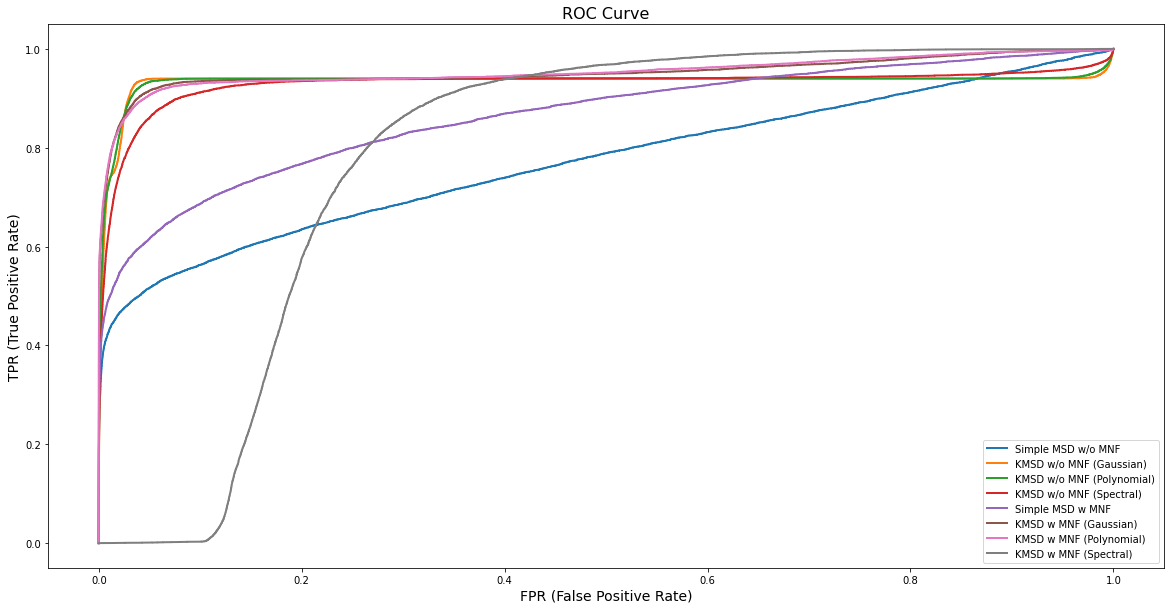

In [15]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# reload all pickle files for plotting 

with open("./kernel_data/y_MSD.pkl","rb") as f:
    y_MSD = pkl.load(f)
with open("./kernel_data/PREDS_MSD.pkl","rb") as f:
    PREDS_MSD = pkl.load(f)
with open("./kernel_data/GT_LABELS_MSD.pkl","rb") as f:
    GT_LABELS_MSD = pkl.load(f)
    
    
with open("./kernel_data/y_KMSD_GRBF.pkl","rb") as f:
    y_KMSD_GRBF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_GRBF.pkl","rb") as f:
    PREDS_KMSD_GRBF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF.pkl","rb") as f:
    GT_LABELS_KMSD_GRBF = pkl.load(f)
    

with open("./kernel_data/y_KMSD_Polynomial.pkl","rb") as f:
    y_KMSD_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_Polynomial.pkl","rb") as f:
    PREDS_KMSD_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial.pkl","rb") as f:
    GT_LABELS_KMSD_Polynomial = pkl.load(f)
    
    
with open("./kernel_data/y_KMSD_SpectralAngle.pkl","rb") as f:
    y_KMSD_SpectralAngle = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle.pkl","rb") as f:
    PREDS_KMSD_SpectralAngle = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle.pkl","rb") as f:
    GT_LABELS_KMSD_SpectralAngle = pkl.load(f)
    

    
with open("./kernel_data/y_MSD_MNF.pkl","rb") as f:
    y_MSD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_MSD_MNF.pkl","rb") as f:
    PREDS_MSD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_MSD_MNF.pkl","rb") as f:
    GT_LABELS_MSD_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KMSD_GRBF_MNF.pkl","rb") as f:
    y_KMSD_GRBF_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_GRBF_MNF.pkl","rb") as f:
    PREDS_KMSD_GRBF_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_GRBF_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_GRBF_MNF = pkl.load(f)
    

with open("./kernel_data/y_KMSD_Polynomial_MNF.pkl","rb") as f:
    y_KMSD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_Polynomial_MNF.pkl","rb") as f:
    PREDS_KMSD_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_Polynomial_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    y_KMSD_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    PREDS_KMSD_SpectralAngle_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KMSD_SpectralAngle_MNF.pkl","rb") as f:
    GT_LABELS_KMSD_SpectralAngle_MNF = pkl.load(f)

############################ Plot 1 - ROC Curve with Various Possible Thresholds #################################    
plt.figure(figsize=(20,10))

# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each

# just a minot hack for y_MSD_MNF here as it was throwing some weird error with list type
# GT_LABELS_MSD, y_MSD = np.array(GT_LABELS_MSD).reshape(-1,1), np.array(y_MSD).reshape(-1,1)
# GT_LABELS_MSD_MNF, y_MSD_MNF = np.array(GT_LABELS_MSD_MNF).reshape(-1,1), np.array(y_MSD_MNF).reshape(-1,1)

fpr_MSD, tpr_MSD, _                              = roc_curve(GT_LABELS_MSD, y_MSD)
fpr_KMSD_GRBF, tpr_KMSD_GRBF, _                  = roc_curve(GT_LABELS_KMSD_GRBF, y_KMSD_GRBF)
fpr_KMSD_Polynomial, tpr_KMSD_Polynomial, _      = roc_curve(GT_LABELS_KMSD_Polynomial, y_KMSD_Polynomial)
fpr_KMSD_SpectralAngle, tpr_KMSD_SpectralAngle,_ = roc_curve(GT_LABELS_KMSD_SpectralAngle, y_KMSD_SpectralAngle)

fpr_MSD_MNF, tpr_MSD_MNF, _                              = roc_curve(GT_LABELS_MSD_MNF, y_MSD_MNF)
fpr_KMSD_GRBF_MNF, tpr_KMSD_GRBF_MNF, _                  = roc_curve(GT_LABELS_KMSD_GRBF_MNF, y_KMSD_GRBF_MNF)
fpr_KMSD_Polynomial_MNF, tpr_KMSD_Polynomial_MNF, _      = roc_curve(GT_LABELS_KMSD_Polynomial_MNF, y_KMSD_Polynomial_MNF)
fpr_KMSD_SpectralAngle_MNF, tpr_KMSD_SpectralAngle_MNF,_ = roc_curve(GT_LABELS_KMSD_SpectralAngle_MNF, y_KMSD_SpectralAngle_MNF)

plot_roc_curve(fpr_MSD, tpr_MSD, label="Simple MSD w/o MNF ")
plot_roc_curve(fpr_KMSD_GRBF, tpr_KMSD_GRBF, label="KMSD w/o MNF (Gaussian)")
plot_roc_curve(fpr_KMSD_Polynomial, tpr_KMSD_Polynomial, label="KMSD w/o MNF (Polynomial)")
plot_roc_curve(fpr_KMSD_SpectralAngle, tpr_KMSD_SpectralAngle, label="KMSD w/o MNF (Spectral)")

plot_roc_curve(fpr_MSD_MNF, tpr_MSD_MNF, label="Simple MSD w MNF ")
plot_roc_curve(fpr_KMSD_GRBF_MNF, tpr_KMSD_GRBF_MNF, label="KMSD w MNF (Gaussian)")
plot_roc_curve(fpr_KMSD_Polynomial_MNF, tpr_KMSD_Polynomial_MNF, label="KMSD w MNF (Polynomial)")
plot_roc_curve(fpr_KMSD_SpectralAngle_MNF, tpr_KMSD_SpectralAngle_MNF, label="KMSD w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
# plt.title("ROC Curve - With Various Possible Threshold", size=16)
plt.title("ROC Curve", size=16)
plt.savefig("./pics/ROC_PossibleThresholds.png")
#############################################################################################################


# # ############################ Plot 2 - ROC Curve with Best Selected Threshold During Testing Above #################################    
# plt.figure(figsize=(20,10))
# # using sklearn's roc_curve method to get FPR, TPR & Thresholds for each
# fpr_MSD, tpr_MSD, _                              = roc_curve(GT_LABELS_MSD, PREDS_MSD)
# fpr_KMSD_GRBF, tpr_KMSD_GRBF, _                  = roc_curve(GT_LABELS_KMSD_GRBF, PREDS_KMSD_GRBF)
# fpr_KMSD_Polynomial, tpr_KMSD_Polynomial, _      = roc_curve(GT_LABELS_KMSD_Polynomial, PREDS_KMSD_Polynomial)
# fpr_KMSD_SpectralAngle, tpr_KMSD_SpectralAngle,_ = roc_curve(GT_LABELS_KMSD_SpectralAngle, PREDS_KMSD_SpectralAngle)

# fpr_MSD_MNF, tpr_MSD_MNF, _                              = roc_curve(GT_LABELS_MSD_MNF, PREDS_MSD_MNF)
# fpr_KMSD_GRBF_MNF, tpr_KMSD_GRBF_MNF, _                  = roc_curve(GT_LABELS_KMSD_GRBF_MNF, PREDS_KMSD_GRBF_MNF)
# fpr_KMSD_Polynomial_MNF, tpr_KMSD_Polynomial_MNF, _      = roc_curve(GT_LABELS_KMSD_Polynomial_MNF, PREDS_KMSD_Polynomial_MNF)
# fpr_KMSD_SpectralAngle_MNF, tpr_KMSD_SpectralAngle_MNF,_ = roc_curve(GT_LABELS_KMSD_SpectralAngle_MNF, PREDS_KMSD_SpectralAngle_MNF)



# plot_roc_curve(fpr_MSD, tpr_MSD, label="Simple MSD w/o MNF ")
# plot_roc_curve(fpr_KMSD_GRBF, tpr_KMSD_GRBF, label="KMSD w/o MNF (Gaussian)")
# plot_roc_curve(fpr_KMSD_Polynomial, tpr_KMSD_Polynomial, label="KMSD w/o MNF (Polynomial)")
# plot_roc_curve(fpr_KMSD_SpectralAngle, tpr_KMSD_SpectralAngle, label="KMSD w/o MNF (Spectral)")

# plot_roc_curve(fpr_MSD_MNF, tpr_MSD_MNF, label="Simple MSD w MNF ")
# plot_roc_curve(fpr_KMSD_GRBF_MNF, tpr_KMSD_GRBF_MNF, label="KMSD w MNF (Gaussian)")
# plot_roc_curve(fpr_KMSD_Polynomial_MNF, tpr_KMSD_Polynomial_MNF, label="KMSD w MNF (Polynomial)")
# plot_roc_curve(fpr_KMSD_SpectralAngle_MNF, tpr_KMSD_SpectralAngle_MNF, label="KMSD w MNF (Spectral)")

# plt.xlabel("FPR (False Positive Rate)", size=14)
# plt.ylabel("TPR (True Positive Rate)", size=14)
# plt.legend()
# plt.title("ROC Curve - With Best Selected Threshold", size=16)

# plt.savefig("./pics/ROC_SelectedThreshold.png")
# # #############################################################################################################